In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

# import logging
# import anndata2ri
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

/tmp/ipykernel_777306/3978997871.py:16: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#import required R packages
# seurat = ro.packages.importr('Seurat') 
soupx = ro.packages.importr('SoupX') 


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [68]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [135]:
#import data from cellranger
adata = sc.read_10x_mtx("./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix", gex_only=False)
adata_raw = sc.read_10x_mtx("./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/count/raw_feature_bc_matrix", gex_only=False)

# Quality Control

### 1. Filter for low quality cells / likely dying cells based on mitochondrial counts per cell; total gene count per cell and total counts per cell, in this case mt counts and gene/total counts are considered together, usually people set random threshhholds.

In [136]:
# select the features of interest for quality control, in this case HTOs and mitochondiral features:
#mitochondrial:
adata.var['mt'] = adata.var_names.str.startswith('mt-') #note for mice its mt for human its MT
#ribosomal:
# adata.var['ribo'] = adata.var_names.str.lower().str.startswith(('rpl', 'rps'))
#HTOs
# adata.var['hto'] = adata.var['feature_types'] == 'Antibody Capture'

In [137]:
#calculate the qc metrics, meaning total umi counts, total gene counts etc...
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=[20], inplace=True) #percent_top=None, log1p=False,

In [7]:
#filter genes and cells, based on :
# sc.pp.filter_genes(adata, min_cells=3) #make sure all genes occur in at least 3 cells
# sc.pp.filter_cells(adata, min_genes=200) #make sure all cells have at least 200 genes, in this case there arent any (cellranger also filters), however since we filter on that anyway with the MAD we do not need it here

##IMPORTANT: only filter out genes, if you do not intent to use SoupX, it requires the genes of the adata_raw and adata to be matching (unequal number of genes leads to errors). 
#So best to postpone this step until after filtering Ambient RNA

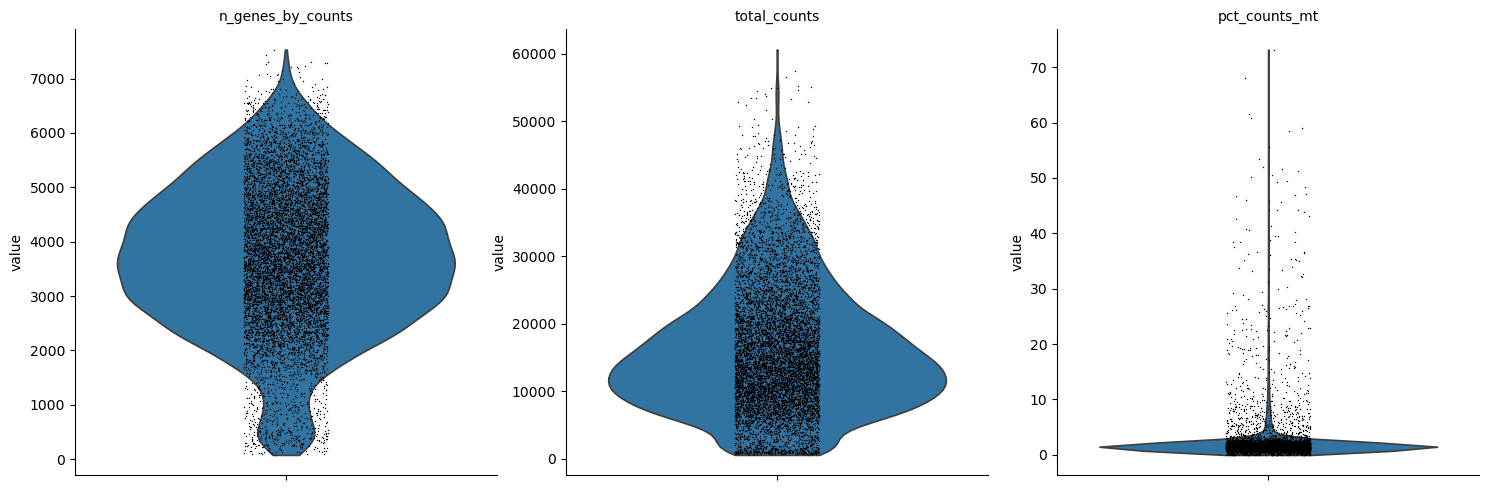

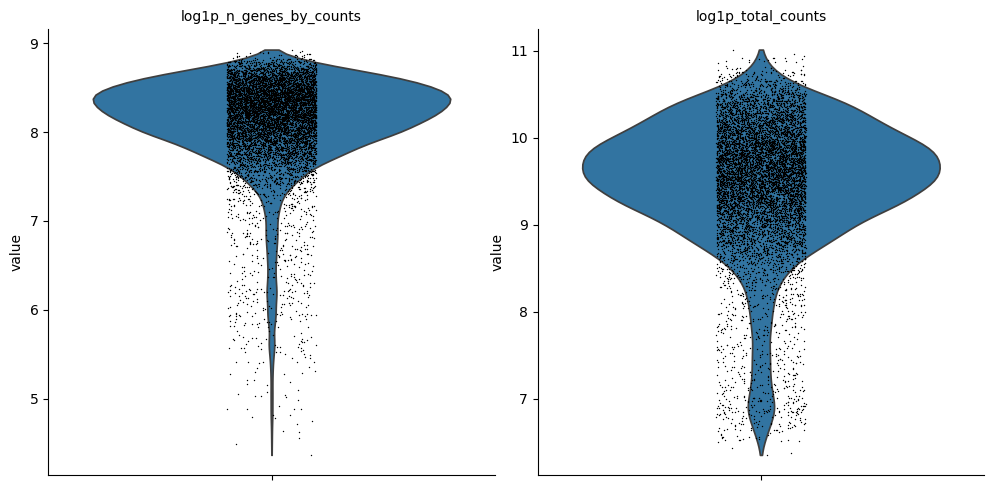

In [11]:
#plot qc metrics, based on this you can decide on what to filter
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True)
sc.pl.violin(adata, ['log1p_n_genes_by_counts', 'log1p_total_counts'], multi_panel=True)

In [138]:
#find outliers in the gene/total counts via MAD
adata.obs["outlier"] = (
    dp.is_mad_outlier(adata, "log1p_total_counts", 5)
    |  dp.is_mad_outlier(adata, "log1p_n_genes_by_counts", 5)
    |  dp.is_mad_outlier(adata, "pct_counts_in_top_20_genes", 5)
    |  dp.is_mad_outlier(adata, "pct_counts_mt", 5) 
    |  (adata.obs["pct_counts_mt"] > 5)
)
adata.obs.outlier.value_counts()

outlier
False    8070
True      954
Name: count, dtype: int64

In [139]:
adata_mad = adata.copy()
adata_mad = adata_mad[(~adata_mad.obs.outlier)]
adata_mad

View of AnnData object with n_obs × n_vars = 8070 × 33699
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

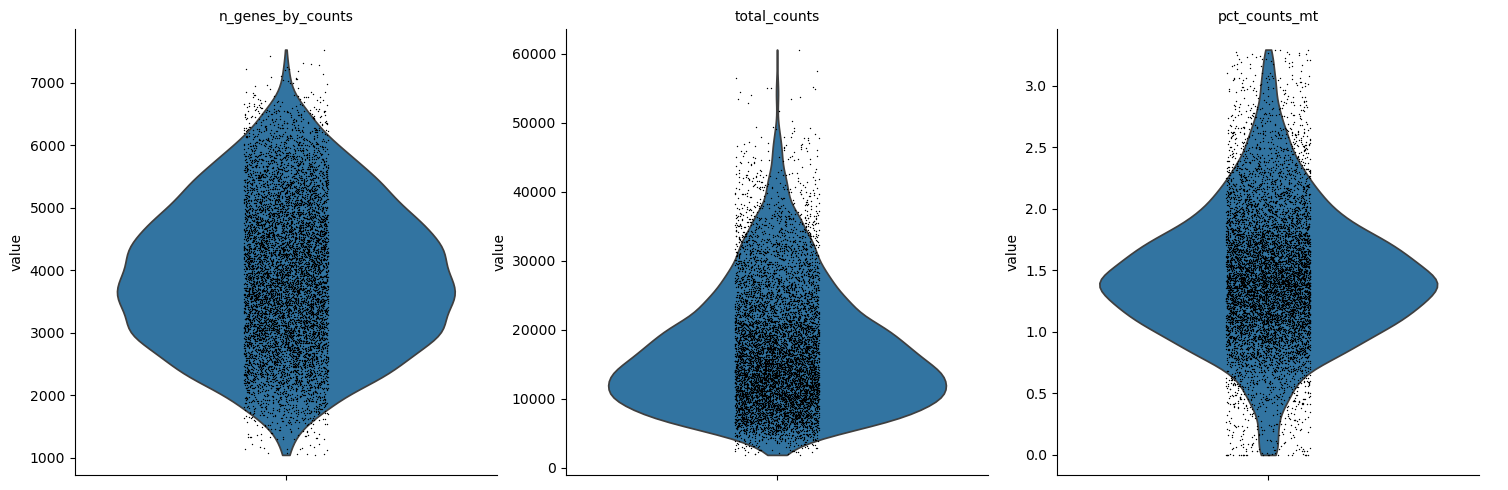

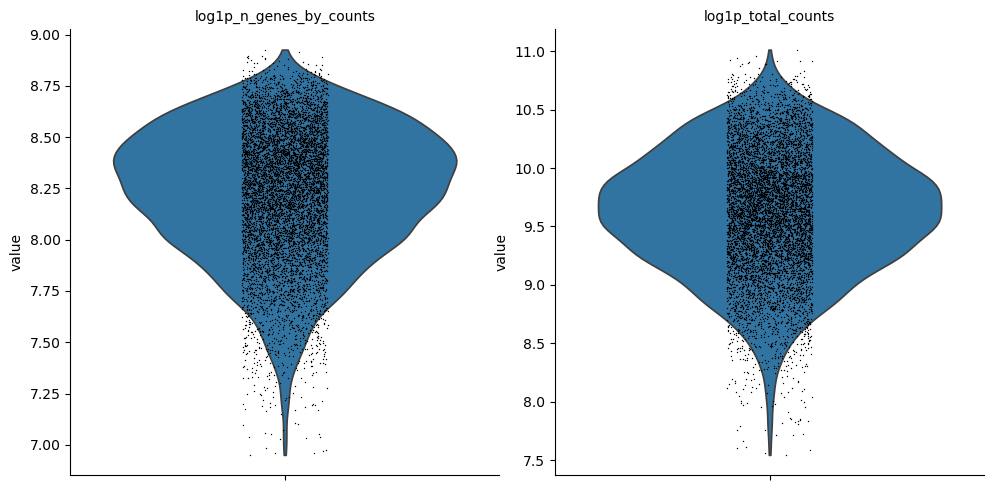

In [34]:
sc.pl.violin(adata_mad, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True)
sc.pl.violin(adata_mad, ['log1p_n_genes_by_counts', 'log1p_total_counts'], multi_panel=True)

In [140]:
adata.obs["outlier"] = (
    dp.is_qntl_outlier(adata, "log1p_total_counts", .01)
    |  dp.is_qntl_outlier(adata, "log1p_n_genes_by_counts", .01)
    |  dp.is_qntl_outlier(adata, "pct_counts_in_top_20_genes", .01)
    |  dp.is_qntl_outlier(adata, "pct_counts_mt", .02)
    |  (adata.obs["pct_counts_mt"] > 5)
)
adata.obs.outlier.value_counts()

outlier
False    8113
True      911
Name: count, dtype: int64

In [141]:
adata_pctl = adata.copy()
adata_pctl = adata_pctl[ (~adata_pctl.obs.outlier)]
adata_pctl

View of AnnData object with n_obs × n_vars = 8113 × 33699
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

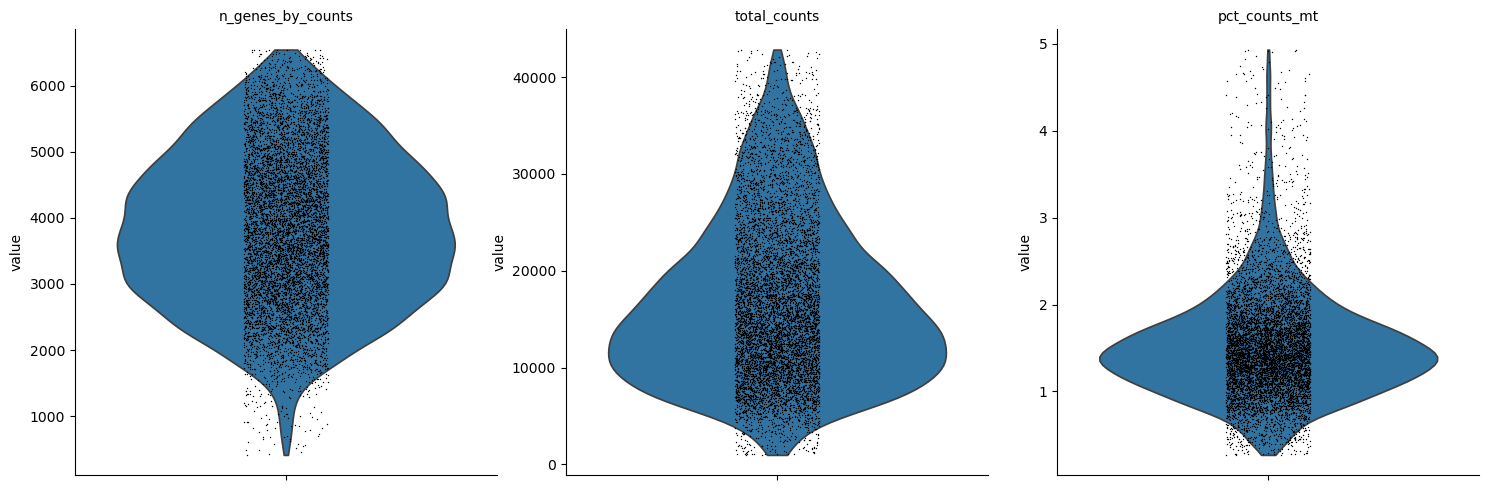

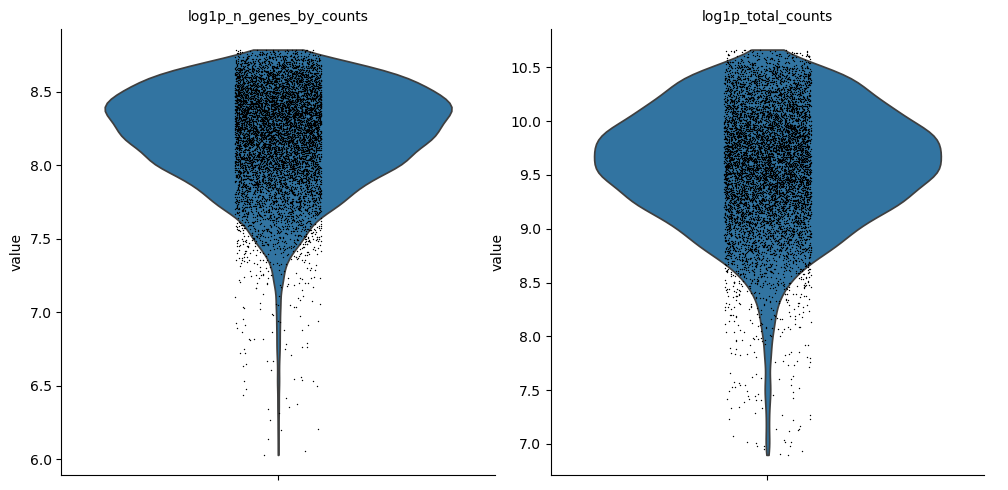

In [37]:
sc.pl.violin(adata_pctl, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True)
sc.pl.violin(adata_pctl, ['log1p_n_genes_by_counts', 'log1p_total_counts'], multi_panel=True)

In [142]:
#continue with mad filtered adata
adata = adata_mad
del adata_mad; del adata_pctl

### 2. Correct for ambient RNA

In [184]:
#eliminate HTOs from adata (and its raw version), it should not be used for soupx, because its not a real gene. Its considered to be a huge contamination since its added in the lab, hence 
#its not like with other genes that cells burst and those genes therefore appear in some other cells, HTOs appear everywhere and especially in empty droplets. Ergo to avoi eliminating your HTO
#counts and overestimating the contamination fraction we leave them out of ambient RNA corrections.
conditions = list(adata.var[adata.var.feature_types == 'Antibody Capture'].gene_ids)
adata = dp.hashing_columns(adata, rename_to=conditions, rm_var_cols=True) 
adata_raw = dp.hashing_columns(adata_raw, rm_var_cols=True) 

In [185]:
#continue with mad filtered adata
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp) #normalize with respect to total counts. Each cell will have in the end the same total count in the end.
sc.pp.log1p(adata_pp) #converts the counts into log1p(counts), meaning it computes ln(1 + count)

In [186]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups", flavor="igraph", n_iterations=2)

# # Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

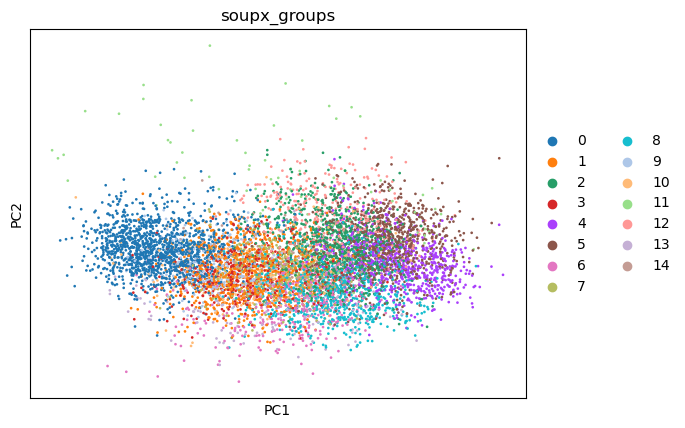

In [187]:
#this gives you the clusters which soupX will use in order to determine marker genes for estimating contamination, In this case I included HTOs
sc.pl.pca(adata_pp, color='soupx_groups')

In [188]:
#In this step, you can manually filter for empty droplets (here defined as all droplets in the raw matrix that have between 0 and 100 counts (dp.find_empty_dops(adata_raw, [0,100])), as recommended by soupX creators)
#this is exactly the same that is done with %R sc = estimateSoup(sc), however this step for some reason does not include genes as rownames, so you'll need to manually set rownames for the soupProfile with:
# %R rownames(sc$soupProfile) <- genes. I much thinks its also more illustrative to use this manual selection step.
empty_drops = dp.find_empty_drops(adata_raw)

In [189]:
#since you cannot transfer the entire adata element to a single cell object in R, you have to split up your data into pieces and put it back together in R
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T
data_raw = adata_raw.X.T

In [190]:
#I am not sure why, but magic %%R does not work, so from now on when using R I will use the %R magic command in each line
%R -i data -i data_raw -i genes -i cells -i soupx_groups -i empty_drops
# specify row and column names of data
%R rownames(data) = genes
%R colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
%R data <- as(data, "sparseMatrix")
%R data_raw <- as(data_raw, "sparseMatrix")
# Generate SoupChannel Object for SoupX 
%R sc = SoupChannel(data_raw, data, calcSoupProfile = FALSE) #technically you do not even need the raw data since the empty droplets were computed manually, you may also use 2x data
#based on the empty droplets, create a bakground/soup gene expression profile
%R soupProf = data.frame(row.names = genes, est = rowSums(empty_drops)/sum(empty_drops), counts = rowSums(empty_drops))
%R sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
%R sc = setClusters(sc, soupx_groups)
# Estimate contamination fraction
%R sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
%R out = adjustCounts(sc, roundToInt = TRUE)
%R -o out

'value'

In [191]:
#This will create 2 layers, the soupX corrected count matrix and the original one. The soupX matrix is corrected for ambient RNA / background
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [207]:
sc.pp.filter_genes(adata, min_cells=20) #make sure all genes occur in at least 20 cells

### 3. Demultiplex and detect doublets using hashsolo from scanpy (which is based on bayesen statistics, hence needs prior probabilitis, which are based on the fact that the filtering above was carried out)

In [212]:
sce.pp.hashsolo(adata, conditions)

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
